In [51]:
import sys
sys.path.append('../')
sys.dont_write_bytecode = True
import numpy as np
from matplotlib.pyplot import *
%matplotlib inline
#matplotlib.rcParams['figure.facecolor'] = [0.37]*3
import numba
#import utils; import utils.index
#from utils.index import *
#from imp import reload
#reload(utils);reload(utils.index)

### FireSim
#### Variable Description
```fires``` - The coordinates of all fires that have burnt. A 2-tuple of (y,x) coordinates

```active``` - A 'cursor' that shows the range of pixels that are currently burning. This will be a contiguous range, as the active pixels will be visited in linear order. Simulation invariant:```active[1]``` is the total number of fires that have started in the whole simulation. The y,x coordinates of these fires is ```(fires[0][:active[1]], fires[1][:active[1]])```

```F``` - The 2d map of all fires that have burnt. The pixel value at ```F[i,j]``` is a boolean value (burnt/not burnt)   

```B``` - The 2d map of biomes. Each biomes is associated with a distribution of land covers. For example, a chapparal biome would have more shrub land cover and a defensible space biome would have more inflammable land cover.

```L``` - The 2d map of land cover types {e.g. }. Each land cover types have burn properties that are drawn from a land-cover specific distribution. Land cover type 0 is inflammable; it will not burn, accumulate energy, or release energy.

```E``` - The 2d accumulated energy. This is the matrix where, after a nearby pixel has burned and transmitted its energy to a neighborhood, the energy is 'stored' or tallied. This builds up over the whole course of the simulation (never decays temporally).

In [52]:
def fill_L(biomes,B,p,L):
    """Fill a LandCover (L) map from a Biome map (B).
    
    [PARAMETERS]
    biomes - tuple(int):
        Sequence of the biomes to fill.
    
    B - 2d numpy.ndarray(int)
        Spatial grid of Biome classes for each pixel.
    
    p - dict(key=int,val=list)
        Look up table that gives the proportion of each land cover (rows)
        in each Biome. t should support indexing for every integer value 
        found in B.
        
    L* - 2d numpy.ndarray(int)
        Land cover drawn from the distributions in t corresponding to each
        Biome type. Identical in shape to B.
    """
    for biome in biomes:
        proportions = p[biome] # Proportion of each land cover class in this biome
        y,x = np.where(B==biome)
        L[y,x] = np.random.choice(len(proportions),y.size,p=proportions)

In [53]:
def fill_A(n_covers, L, rngs, A):
    """Fill the Activation Energy map (A) with randomly generated values.
    
    [PARAMETERS]
    L - 2d numpy.ndarray(int)
        2d map of andcover component type (e.g. bare, grass, etc.)
        
    rngs - dict(key=int,value=callable)
        A dict of callable objects (e.g. functions). There should be one
        entry in the dictionary for each landcover component class. The 
        dictionary contains callables that takes an integer n and
        returns a 1 dimensional numpy.ndarray(float) that has size n and 
        contains random values.
    
    A* - 2d numpy.ndarray(int)
        The array to be filled with random activation energies based
        on the land cover component.
    """
    for lc in range(n_covers):
        y,x = np.where(L==lc)
        if len(y):
            A[y,x] = rngs[lc](y.size)

In [54]:
def fill_R(n_covers, L, rngs, R):
    """Fill the Release Energy map (R) with randomly generated values.
    
    [PARAMETERS]
    n_covers - int
        Max number of unique cover classes in L
    
    L - 2d numpy.ndarray(int)
        Map of landcover component type (e.g. bare, grass, etc.)
    
    rngs - tuple(one parameter callables) of len(n_covers)
        A sequence of callable objects (e.g. functions). There should
        be one entry in rngs for each landcover component class. Each
        callable in rngs should take one parameter, an int n, and should
        generate n random values corresponding to the land cover class.
        
    R* - 2d numpy.ndarray(int)
        The array to be filled with random release energies based
        on the land cover component and the distribution.
    """
    fill_A(n_covers,L,rngs,R)  # Same functionality as fill_A

In [63]:
import math
@numba.jit(nopython=True)
def euclidean_distance(y1,x1,y2,x2):
    '''Find the Euclidean distance between two points'''
    return math.sqrt( ((x1-x2)*(x1-x2)) + ((y1-y2)*(y1-y2)) )


@numba.jit(nopython=True)
def weight_distance(dist):
    """How do we weight transmitted energy with distance?"""
    return 1/(dist*dist)


_MAX_KERNEL_RADIUS_ = 10
def find_kernel_denominator():
    """Find the denominator so that energy release integrates to 1."""
    total = 0
    for iy in range(-_MAX_KERNEL_RADIUS_,_MAX_KERNEL_RADIUS_+1):
        for ix in range(-_MAX_KERNEL_RADIUS_,_MAX_KERNEL_RADIUS_+1):
            if iy==0 and ix == 0:
                continue
            dist = euclidean_distance(0,0,iy,ix)
            if dist > _MAX_KERNEL_RADIUS_:
                continue
            total += weight_distance(dist)
    return total

_KERNEL_DENOMINATOR_ = find_kernel_denominator()
print(_KERNEL_DENOMINATOR_)

17.079015524761836


Fires lit: 1
Amean 0.1
active after burn [0 1]
30.0


C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


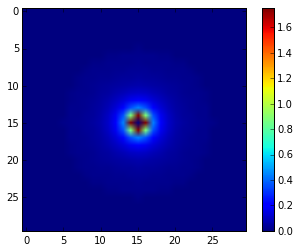

In [174]:
# TODO: Test that a unit of energy given to all neighbors is one
test_size = 30,30
L = np.ones(test_size,dtype=int)
E = np.zeros(test_size,dtype=float)
A = np.zeros_like(E)
A[:] = 0.1
R = np.zeros_like(E)
F = np.zeros(test_size,dtype=int)

y,x = np.array([15]), np.array([15])
fires = np.zeros(1000, dtype=int), np.zeros(1000, dtype=int)
active = np.array([0,0],dtype=int)
fire_successfully_lit = ignite_fires((y,x),fires,active,F)
print('Fires lit:',fire_successfully_lit)


print('Amean',np.mean(A))
R[y, x] = 30

#burn_next_active_pixel(fires,active,L,E,A,R,F)
print('active after burn',active)
burn_all(fires, active, L, E, A, R, F)

imshow(E)
colorbar()

print(np.sum(E))
assert np.sum(E) == R[y, x]

C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


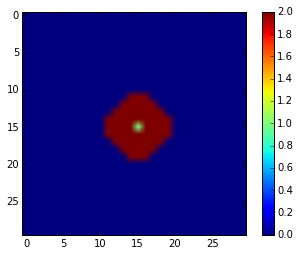

In [175]:
imshow(F)
colorbar()

In [147]:
@numba.jit(nopython=True)
def burn_next_active_pixel(fires,active,L,E,A,R,F):
    """Apply the Released Energy in a burnt pixel to neighbors.
    
    Arguments
        
        fires - tuple(numpy.ndarray(dtype=int))
            2-tuple of y and x coordinates of active or past fires
        active - tuple(ints)
            (start,end] coordinates of the currently burning fires
        L,E,A,R,F - Environmental fields.
    """
    Y, X = E.shape
    y, x = fires[0][active[0]], fires[1][active[0]]
    fire_time_step = F[y, x]
    
    for iy in range(y-_MAX_KERNEL_RADIUS_,y+_MAX_KERNEL_RADIUS_+1):
        if iy<0 or iy>=Y: continue
        for ix in range(x-_MAX_KERNEL_RADIUS_,x+_MAX_KERNEL_RADIUS_+1):
            
            # Bounds checking (or if this pixel has already been burned)
            if ix<0 or ix>=X or (y==iy and x==ix) or (L[iy,ix]==0) or F[iy,ix]:
                continue
            
            # If we're inside of max radius
            dist = euclidean_distance(y,x,iy,ix)
            if dist <= _MAX_KERNEL_RADIUS_:  # Apply the energy to the neighbor
                E[iy,ix] +=  R[y,x] * weight_distance(dist)/_KERNEL_DENOMINATOR_
            
            # If we've exceeded Activation, add this pixel to the burn list
            if E[iy,ix] > A[iy,ix]:
                fires[0][active[1]] = iy
                fires[1][active[1]] = ix
                F[iy,ix] = fire_time_step + 1
                active[1] += 1
    active[0] += 1  # Set the next pixel as 'next'
    return True

In [148]:
#@numba.jit(nopython=True)
def burn_all(fires, cursor, L, E, A, R, F, n=-1):
    """Burn until there are no more active fires."""
    while n and (active[0] != active[1]):
        burn_next_active_pixel(fires, active, L, E, A, R, F)
        if n: n -= 1
        else: break
    return abs(n)

In [78]:
#@numba.jit(nopython=True)
def ignite_fires(ignitions, fires, active, F):
    """Add active fires to the simulation.
    
    Parameters:
        locations - 2-tuple(numpy.ndarray(int))
            y,x locations for N ignition points.
        
        fires* - 2-tuple(numpy.ndarray(int))
            Tuple of y,x pixel coordinates of all fires. Ignitions will
            be added to the end of this list. cursor will be modified so
            that it points to one past the last new fire added to this list.
        
        cursor* - numpy.ndarray(int,shape=(2,))
            First and last+1 indices of active fires.
        
        F* - 2d numpy.array(bool)
            Map of burnt and burning pixels.
    """
    #print('ign',ignitions)
    #print('ign[0]',ignitions[0])
    N = len(ignitions[0])
    n_actual = 0
    offset = active[1]
    for i in range(N):
        y, x = ignitions[0][i], ignitions[1][i]
        if L[y, x] == BARE or F[y, x]:
            continue
        n_actual += 1
        fires[0][i+offset] = y
        fires[1][i+offset] = x
        F[y, x] = True
        active[1] += 1
    return n_actual


def build_fires(L,F):
    """Given a map of fires, build a list of fires and a cursor."""
    fires = np.zeros(shape=(F.size,2),dtype=int)
    F[L==BARE] = False # Cannot light bare ground
    y,x = np.where(F==True)
    N = y.size
    fires[:N,0] = y
    fires[:N,1] = x
    cursor = np.array([0,N])
    F[:] = False
    return fires,cursor

In [48]:
def parameterize_distribution(distr,p1,p2):
    """Turn a two-parameter distribution into a callable.
    
    Returns a callable that takes one parameter:
        The number of samples to draw.
    """
    
    def truncated_rng(n):
        """Truncated, parameterized distribution."""
        x = distr(p1,p2,size=n)
        x[x<0] = 0
        return x
    
    return truncated_rng

my_norm = parameterize_distribution(np.random.normal,10,3)
np.std(my_norm(1000000))
np.mean(my_norm(1000000))

9.9979245548102931

In [49]:
N_BIOMES = 3
N_LANDCOVERS = 3
INFLAMMABLE,DEFENSIBLE_SPACE,CHAPARRAL = 0,1,2

# Land Cover Type:
landcover_components = (
# p(Bare)   p(Grass)  p(Shrub)
( 1.00,      0.00,     0.00    ), # Inflammable
( 0.50,      0.45,     0.05    ), # Defensible Space
( 0.10,      0.20,     0.70    )) # Chaparral
                        
N_COMPONENTS = 3
BARE,GRASS,SHRUB = 0,1,2
MU,SIGMA,BETA,GAMMA = 0,1,2,3

distr = np.random.normal # Needs to be a 2 param distribution
params = {#        [    RELEASED   ]   [   ACTIVATION   ]
          # COVER:   MU       SIGMA     BETA     GAMMA
            BARE:  [ np.nan,  np.nan,   np.nan,  np.nan],
            GRASS: [ 01.00,   00.10,    0.53,   03.01  ],
            SHRUB: [ 04.50,   01.40,    1.50,   00.50  ]}

R_distr = tuple(parameterize_distribution(distr,params[i][0],params[i][1])
                for i in sorted(params))

A_distr = tuple(parameterize_distribution(distr,params[i][2],params[i][3])
                for i in sorted(params))

grid_dims = (100,100)
cell_size_m = 10 # meters

B = np.zeros(shape=grid_dims,dtype=int)
B[int(grid_dims[0]/3):int(2*grid_dims[0]/3)] = 1
B[int(2*grid_dims[0]/3):] = 2

L = np.zeros_like(B,dtype=int)
E = np.zeros_like(B,dtype=float)
A = np.zeros_like(B,dtype=float)
R = np.zeros_like(B,dtype=float)
F = np.zeros_like(B,dtype=bool)

fill_L(B,landcover_components,L)
E[L==0] = np.nan
fill_A(N_LANDCOVERS, L, A_distr, A)
fill_R(N_LANDCOVERS, L, R_distr, R)
F[66:69] = True
fires,cursor = build_fires(L, F)
burn(fires, cursor, L, E, A, R, F)
print("Cursor:",cursor)

NameError: name 'rng' is not defined

In [114]:
A

array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ..., 
       [ 2.06398871,  1.61642312,  0.94364551, ...,         nan,
         1.36459161,  2.18302409],
       [ 7.66791234,  0.94118963,  1.62122592, ...,         nan,
         1.71061098,  0.        ],
       [ 2.45333827,  1.280769  ,  0.25113412, ...,  1.96696472,
         1.5200034 ,  0.68054915]])

(array([  2.02900000e+03,   2.10200000e+03,   2.97000000e+02,
          1.50000000e+02,   9.00000000e+01,   4.70000000e+01,
          2.50000000e+01,   4.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([  0.        ,   1.22604091,   2.45208181,   3.67812272,
          4.90416362,   6.13020453,   7.35624543,   8.58228634,
          9.80832724,  11.03436815,  12.26040905]),
 <a list of 10 Patch objects>)

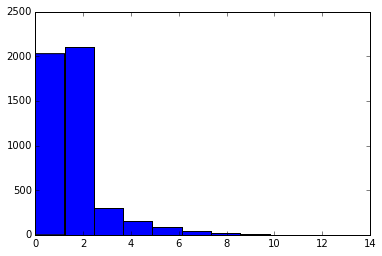

In [119]:
hist((A[np.isfinite(A)]).flatten())

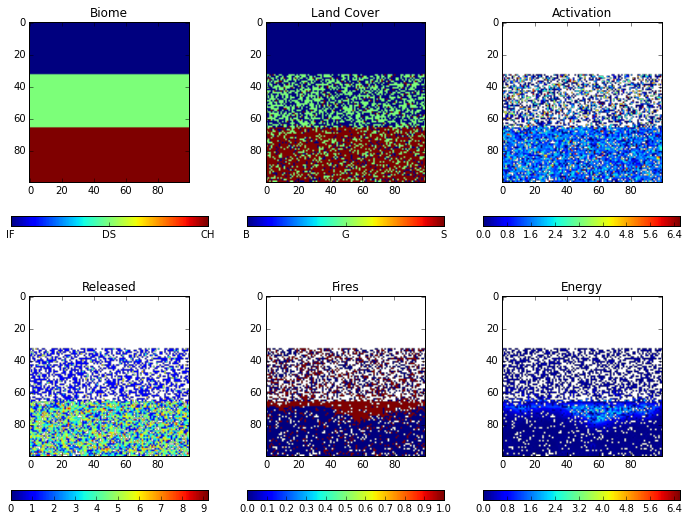

In [120]:
f = figure(figsize=(12,9))

f.add_subplot(231)
imshow(B); title('Biome')
cbar=colorbar(orientation='horizontal',ticks=[0,1,2])
cbar.ax.set_xticklabels(['IF','DS','CH'])

f.add_subplot(232)
imshow(L); title('Land Cover')
cbar=colorbar(orientation='horizontal',ticks=[0,1,2])
cbar.ax.set_xticklabels(['B','G','S'])

f.add_subplot(233)
not_nan = np.isfinite(A)
pct = np.percentile(A[not_nan],99)
imshow(A); title('Activation')
clim(0,pct)
colorbar(orientation='horizontal')

f.add_subplot(234)
imshow(R); title('Released')
cbar=colorbar(orientation='horizontal')

f.add_subplot(235)
_f = np.copy(F).astype(float)
_f[L==0] = np.nan
imshow(_f); title('Fires')
clim(0,1)
colorbar(orientation='horizontal')
#xticks([])

f.add_subplot(236)
imshow(E); title('Energy');
clim(0,pct)
colorbar(orientation='horizontal')

#tight_layout()
#savefig("/Users/Michael_Saha/Repositories/fire_sim/fire_sim.png",dpi=300)

In [111]:
"""A fire simulation."""
class Simulation:
    def __init__(self,B,lc_params,distr,ar_params):
        self.shape = B.shape
        self.B = B
        self.L = np.zeros_like(B,dtype=int)
        self.E = np.zeros_like(B,dtype=float)
        self.A = np.zeros_like(B,dtype=float)
        self.R = np.zeros_like(B,dtype=float)
        self.F = np.zeros_like(B,dtype=int)
        self.lc_params = lc_params
        self.ar_params = ar_params
        self.distr = distr
        self.R_distr = {i:parameterize(distr,params[i][0],params[i][1]) for i in sorted(params)}
        self.A_distr = {i:parameterize(distr,params[i][2],params[i][3]) for i in sorted(params)}
        self.fires[:] = np.zeros(shape=(B.size,2),dtype=int)
        self.reset()
        
    def reset():
        """Generate new random fields for simulation."""
        fill_L(self.B,lc_params,self.L)
        fill_A(self.L,self.A_distr,self.A)
        fill_R(self.R,self.R_distr,self.R)
        self.E[:] = 0.0
        self.E[L==0] = np.nan
        self.fires[:]
    
    def run(self):
        pass
### Implement Gamma
### Can we derive the integral of the Gamma distribution
### To get the expected value of exceedance?
sim = Simulation(B)
sim.B

TypeError: __init__() missing 3 required positional arguments: 'lc_params', 'distr', and 'ar_params'

In [18]:
np.array([0,0,0,1,1,1],dtype=bool).astype(float)

array([ 0.,  0.,  0.,  1.,  1.,  1.])